This notebook contains the Wild Animals Sounds prediction. We've worked with Librosa methods to extract the MFCC Features. Then we've predicted the animals audios with Neural Networks.

## Importing libraries

In [1]:
import glob
import pandas as pd 
import math
import secrets
from sklearn.model_selection import train_test_split
import numpy as np
import pathlib
import librosa
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
import scikitplot as skplt
import matplotlib.pyplot as plt
import seaborn as sns

## Creating an ID generator for the test set

In [2]:
def random_alphanum(length: int) -> str:
        text = secrets.token_hex(nbytes=math.ceil(length / 2))
        isEven = length % 2 == 0
        return text if isEven else text[1:]

## Creating a training set

In [3]:
# assign directory
directory = '.\dataset'
 
# iterate over files in
# that directory
dataset_dict = {
    'relative_path' : [],
    'classID' : [],
    'id_file' : []
}
sum1 = 0
relative_path = []
classID = []
id_file = []
for filename in glob.iglob(f'{directory}/*'):
    for audio_name in glob.iglob(f'{filename}/*'):
        audio_name = audio_name.replace("\\", "/")
        print("filename : ", audio_name)
        relative_path.append(audio_name)
        classID.append(filename.split("\\")[-1])
        
cpt = 0
for filename in glob.iglob(f'{directory}/*'):
    for audio_name in glob.iglob(f'{filename}/*'):  
        cpt += 1

for i in range(cpt):
    id_file.append(random_alphanum(6))
dataset_dict['relative_path'] = relative_path
dataset_dict['classID'] = classID
dataset_dict['id_file'] = id_file
df_dataset = pd.DataFrame(dataset_dict, columns = ['relative_path', 'classID', 'id_file'])
# print("Mean duration : ", sum1/len(list(glob.iglob(f'{directory}/*'))))

filename :  ./dataset/bear/416860__tbsounddesigns__beargrowl-02-noise_add-nb-0.wav
filename :  ./dataset/bear/416860__tbsounddesigns__beargrowl-02-pitching-nb-0-step--5.wav
filename :  ./dataset/bear/416860__tbsounddesigns__beargrowl-02-pitching-nb-1-step--4.wav
filename :  ./dataset/bear/416860__tbsounddesigns__beargrowl-02-pitching-nb-2-step--3.wav
filename :  ./dataset/bear/416860__tbsounddesigns__beargrowl-02-pitching-nb-3-step--2.wav
filename :  ./dataset/bear/416860__tbsounddesigns__beargrowl-02-shifting-nb-0.wav
filename :  ./dataset/bear/416860__tbsounddesigns__beargrowl-02-t-sttch-nb-0.wav
filename :  ./dataset/bear/416860__tbsounddesigns__beargrowl-02.wav
filename :  ./dataset/bear/439441__asteroiderer__bear-mad-noise_add-nb-0.wav
filename :  ./dataset/bear/439441__asteroiderer__bear-mad-pitching-nb-0-step--5.wav
filename :  ./dataset/bear/439441__asteroiderer__bear-mad-pitching-nb-1-step--4.wav
filename :  ./dataset/bear/439441__asteroiderer__bear-mad-pitching-nb-2-step--3.w

## Creating a prediction set

In [4]:
# assign directory
directory = '.\prediction set'
 
# iterate over files in
# that directory
test_dict = {
    'relative_path' : [],
    'classID' : [],
    'id_file' : []
}
sum1 = 0
relative_path = []
classID = []
id_file = []
for filename in glob.iglob(f'{directory}/*'):
    for audio_name in glob.iglob(f'{filename}/*'):
        audio_name = audio_name.replace("\\", "/")
        print("filename : ", audio_name)
        relative_path.append(audio_name)
        classID.append(filename.split("\\")[-1])
        
cpt = 0
for filename in glob.iglob(f'{directory}/*'):
    for audio_name in glob.iglob(f'{filename}/*'):  
        cpt += 1

for i in range(cpt):
    id_file.append(random_alphanum(6))
    
test_dict['relative_path'] = relative_path
test_dict['classID'] = classID
test_dict['id_file'] = id_file
df_test = pd.DataFrame(test_dict, columns = ['relative_path', 'classID', 'id_file'])
# print("Mean duration : ", sum1/len(list(glob.iglob(f'{directory}/*'))))

filename :  ./prediction set/bear/439441__asteroiderer__bear-mad.wav
filename :  ./prediction set/crow/138344__unclesigmund__crow.wav
filename :  ./prediction set/dolphin/456151__jfournier18__dolphin-noise.wav
filename :  ./prediction set/eagle/104911__kabit__eagle.wav
filename :  ./prediction set/elephant/139875__y89312__44.wav
filename :  ./prediction set/falcon/467704__tallareta__halcon.wav
filename :  ./prediction set/frog/67261__benboncan__frog-croaking.wav
filename :  ./prediction set/hippo/194871__toadie__hippos-2.mp3
filename :  ./prediction set/lion/69570__bidone__lion-loud.mp3
filename :  ./prediction set/monkey/128473__darkozl__a-monkey.wav
filename :  ./prediction set/owl/25945__inchadney__owl.wav
filename :  ./prediction set/panther/black-panther-roaring-128-ytshorts.savetube.me.mp3
filename :  ./prediction set/Penguin/463033__iamaviolin__penguin-calls-noises.wav
filename :  ./prediction set/seal/179586__stormpetrel__a-weddell-seal-pup-laying-on-the-antarctic-ice-shelf-is-

In [5]:
df_test["relative_path"] = df_test["relative_path"].apply(lambda x: x.replace("./prediction set/", "./dataset/"))

In [6]:
le = LabelEncoder()
df_dataset['classID'] = le.fit_transform(df_dataset['classID'])
df_test['classID'] = le.transform(df_test['classID'])

In [7]:
df_dataset = df_dataset[~(df_dataset["relative_path"].isin(
                        df_test["relative_path"]).values)]

In [8]:
df_test["relative_path"] = df_test["relative_path"].apply(lambda x: x.replace("./dataset/", "./prediction set/"))

## Features Extraction

In [9]:
def features_extractor(file):
    #load the file (audio)
    audio, sample_rate = librosa.load(file, res_type='kaiser_fast') 
    #we extract mfcc
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    #in order to find out scaled feature we do mean of transpose of value
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    return mfccs_scaled_features

In [29]:
### Now we iterate through every audio file and extract features 
### using Mel-Frequency Cepstral Coefficients
extracted_features=[]
for index_num,row in tqdm(df_dataset.iterrows()):
    final_class_labels=row["classID"]
    data=features_extractor(row["relative_path"])
    extracted_features.append([data,final_class_labels])

60it [00:04, 22.66it/s]C:\Users\berra\AppData\Roaming\Python\Python39\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
414it [00:46,  8.86it/s]


In [30]:
### converting extracted_features to Pandas dataframe
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])

## Generating the training and in-sample test sets

In [31]:
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0, stratify=y)

In [32]:
df_Dm_train_y = pd.get_dummies(y_train).values

In [33]:
df_Dm_test_y = pd.get_dummies(y_test).values

## Defining an ideal accuracy to be achieved during training

In [69]:
ACCURACY_THRESHOLD = 0.89
class BPredCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > ACCURACY_THRESHOLD):
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))
            self.model.stop_training = True

callbacks = BPredCallback()

## Training the Neural Network Model

In [70]:
nb_classes = 18
nb_features = 40
model = tf.keras.Sequential(
    [
        layers.Dense(220, activation='relu', input_shape=(nb_features,)),
        layers.Dropout(.2),
        layers.Dense(220, activation="relu"),
        layers.Dropout(.2),
        layers.Dense(220, activation="relu"),
        layers.Dropout(.2),
        layers.Dense(nb_classes, activation="softmax"),
    ]
)

model.compile(optimizer=Adam(lr=0.00005), loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(
    X_train,
    df_Dm_train_y,
    epochs=4000,
    batch_size=12,
    validation_data=(X_test, df_Dm_test_y),
    callbacks=[callbacks]
)


Epoch 1/4000


C:\Users\berra\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


28/28 [==============================] - 1s 8ms/step - loss: 5.3452 - accuracy: 0.0393 - val_loss: 1.1153 - val_accuracy: 0.0602
Epoch 2/4000
28/28 [==============================] - 0s 5ms/step - loss: 2.6857 - accuracy: 0.0695 - val_loss: 0.7214 - val_accuracy: 0.1325
Epoch 3/4000
28/28 [==============================] - 0s 5ms/step - loss: 1.8288 - accuracy: 0.0604 - val_loss: 0.8302 - val_accuracy: 0.1205
Epoch 4/4000
28/28 [==============================] - 0s 4ms/step - loss: 1.5881 - accuracy: 0.0604 - val_loss: 0.8690 - val_accuracy: 0.1084
Epoch 5/4000
28/28 [==============================] - 0s 5ms/step - loss: 1.4789 - accuracy: 0.0514 - val_loss: 0.8782 - val_accuracy: 0.1325
Epoch 6/4000
28/28 [==============================] - 0s 5ms/step - loss: 1.4502 - accuracy: 0.0514 - val_loss: 0.8649 - val_accuracy: 0.1205
Epoch 7/4000
28/28 [==============================] - 0s 4ms/step - loss: 1.3017 - accuracy: 0.0876 - val_loss: 0.8367 - val_accuracy: 0.1325
Epoch 8/4000
28/28 

28/28 [==============================] - 0s 4ms/step - loss: 0.3299 - accuracy: 0.1843 - val_loss: 0.1676 - val_accuracy: 0.3614
Epoch 59/4000
28/28 [==============================] - 0s 4ms/step - loss: 0.3491 - accuracy: 0.1813 - val_loss: 0.1668 - val_accuracy: 0.3373
Epoch 60/4000
28/28 [==============================] - 0s 4ms/step - loss: 0.3473 - accuracy: 0.1360 - val_loss: 0.1674 - val_accuracy: 0.3253
Epoch 61/4000
28/28 [==============================] - 0s 3ms/step - loss: 0.3487 - accuracy: 0.1420 - val_loss: 0.1672 - val_accuracy: 0.3373
Epoch 62/4000
28/28 [==============================] - 0s 4ms/step - loss: 0.3357 - accuracy: 0.1843 - val_loss: 0.1680 - val_accuracy: 0.3494
Epoch 63/4000
28/28 [==============================] - 0s 4ms/step - loss: 0.3230 - accuracy: 0.1752 - val_loss: 0.1674 - val_accuracy: 0.3735
Epoch 64/4000
28/28 [==============================] - 0s 4ms/step - loss: 0.3293 - accuracy: 0.1782 - val_loss: 0.1665 - val_accuracy: 0.3976
Epoch 65/4000

28/28 [==============================] - 0s 4ms/step - loss: 0.2210 - accuracy: 0.2810 - val_loss: 0.1799 - val_accuracy: 0.4458
Epoch 116/4000
28/28 [==============================] - 0s 4ms/step - loss: 0.2288 - accuracy: 0.2326 - val_loss: 0.1812 - val_accuracy: 0.4458
Epoch 117/4000
28/28 [==============================] - 0s 3ms/step - loss: 0.2234 - accuracy: 0.2719 - val_loss: 0.1808 - val_accuracy: 0.4337
Epoch 118/4000
28/28 [==============================] - 0s 4ms/step - loss: 0.2156 - accuracy: 0.2840 - val_loss: 0.1803 - val_accuracy: 0.4337
Epoch 119/4000
28/28 [==============================] - 0s 4ms/step - loss: 0.2177 - accuracy: 0.2568 - val_loss: 0.1815 - val_accuracy: 0.4217
Epoch 120/4000
28/28 [==============================] - 0s 4ms/step - loss: 0.2331 - accuracy: 0.2326 - val_loss: 0.1811 - val_accuracy: 0.4217
Epoch 121/4000
28/28 [==============================] - 0s 4ms/step - loss: 0.2078 - accuracy: 0.2840 - val_loss: 0.1807 - val_accuracy: 0.4217
Epoch 1

Epoch 172/4000
28/28 [==============================] - 0s 3ms/step - loss: 0.1756 - accuracy: 0.3988 - val_loss: 0.1485 - val_accuracy: 0.6145
Epoch 173/4000
28/28 [==============================] - 0s 3ms/step - loss: 0.1799 - accuracy: 0.3867 - val_loss: 0.1472 - val_accuracy: 0.6145
Epoch 174/4000
28/28 [==============================] - 0s 4ms/step - loss: 0.1714 - accuracy: 0.3958 - val_loss: 0.1471 - val_accuracy: 0.6265
Epoch 175/4000
28/28 [==============================] - 0s 4ms/step - loss: 0.1773 - accuracy: 0.3958 - val_loss: 0.1478 - val_accuracy: 0.6386
Epoch 176/4000
28/28 [==============================] - 0s 4ms/step - loss: 0.1671 - accuracy: 0.3837 - val_loss: 0.1475 - val_accuracy: 0.6265
Epoch 177/4000
28/28 [==============================] - 0s 3ms/step - loss: 0.1723 - accuracy: 0.4018 - val_loss: 0.1465 - val_accuracy: 0.6506
Epoch 178/4000
28/28 [==============================] - 0s 4ms/step - loss: 0.1817 - accuracy: 0.3867 - val_loss: 0.1467 - val_accuracy:

Epoch 229/4000
28/28 [==============================] - 0s 3ms/step - loss: 0.1454 - accuracy: 0.4683 - val_loss: 0.1215 - val_accuracy: 0.7229
Epoch 230/4000
28/28 [==============================] - 0s 3ms/step - loss: 0.1418 - accuracy: 0.4985 - val_loss: 0.1225 - val_accuracy: 0.7349
Epoch 231/4000
28/28 [==============================] - 0s 4ms/step - loss: 0.1384 - accuracy: 0.5076 - val_loss: 0.1209 - val_accuracy: 0.7108
Epoch 232/4000
28/28 [==============================] - 0s 4ms/step - loss: 0.1424 - accuracy: 0.4955 - val_loss: 0.1191 - val_accuracy: 0.7349
Epoch 233/4000
28/28 [==============================] - 0s 4ms/step - loss: 0.1401 - accuracy: 0.5196 - val_loss: 0.1191 - val_accuracy: 0.7229
Epoch 234/4000
28/28 [==============================] - 0s 4ms/step - loss: 0.1406 - accuracy: 0.5347 - val_loss: 0.1167 - val_accuracy: 0.7108
Epoch 235/4000
28/28 [==============================] - 0s 4ms/step - loss: 0.1373 - accuracy: 0.5106 - val_loss: 0.1156 - val_accuracy:

Epoch 286/4000
28/28 [==============================] - 0s 4ms/step - loss: 0.1101 - accuracy: 0.6284 - val_loss: 0.0904 - val_accuracy: 0.7349
Epoch 287/4000
28/28 [==============================] - 0s 4ms/step - loss: 0.1077 - accuracy: 0.6344 - val_loss: 0.0900 - val_accuracy: 0.7349
Epoch 288/4000
28/28 [==============================] - 0s 4ms/step - loss: 0.1104 - accuracy: 0.5952 - val_loss: 0.0890 - val_accuracy: 0.7470
Epoch 289/4000
28/28 [==============================] - 0s 3ms/step - loss: 0.1100 - accuracy: 0.6073 - val_loss: 0.0888 - val_accuracy: 0.7590
Epoch 290/4000
28/28 [==============================] - 0s 3ms/step - loss: 0.1093 - accuracy: 0.6042 - val_loss: 0.0892 - val_accuracy: 0.7590
Epoch 291/4000
28/28 [==============================] - 0s 4ms/step - loss: 0.1093 - accuracy: 0.6193 - val_loss: 0.0882 - val_accuracy: 0.7590
Epoch 292/4000
28/28 [==============================] - 0s 4ms/step - loss: 0.1039 - accuracy: 0.6073 - val_loss: 0.0877 - val_accuracy:

Epoch 343/4000
28/28 [==============================] - 0s 3ms/step - loss: 0.0853 - accuracy: 0.7221 - val_loss: 0.0707 - val_accuracy: 0.8072
Epoch 344/4000
28/28 [==============================] - 0s 4ms/step - loss: 0.0858 - accuracy: 0.7251 - val_loss: 0.0701 - val_accuracy: 0.7952
Epoch 345/4000
28/28 [==============================] - 0s 4ms/step - loss: 0.0871 - accuracy: 0.7221 - val_loss: 0.0697 - val_accuracy: 0.8072
Epoch 346/4000
28/28 [==============================] - 0s 3ms/step - loss: 0.0893 - accuracy: 0.6737 - val_loss: 0.0699 - val_accuracy: 0.7952
Epoch 347/4000
28/28 [==============================] - 0s 3ms/step - loss: 0.0805 - accuracy: 0.7341 - val_loss: 0.0691 - val_accuracy: 0.8072
Epoch 348/4000
28/28 [==============================] - 0s 3ms/step - loss: 0.0832 - accuracy: 0.7432 - val_loss: 0.0690 - val_accuracy: 0.8072
Epoch 349/4000
28/28 [==============================] - 0s 4ms/step - loss: 0.0822 - accuracy: 0.7311 - val_loss: 0.0688 - val_accuracy:

Epoch 400/4000
28/28 [==============================] - 0s 4ms/step - loss: 0.0664 - accuracy: 0.8006 - val_loss: 0.0550 - val_accuracy: 0.8434
Epoch 401/4000
28/28 [==============================] - 0s 4ms/step - loss: 0.0664 - accuracy: 0.7976 - val_loss: 0.0553 - val_accuracy: 0.8313
Epoch 402/4000
28/28 [==============================] - 0s 5ms/step - loss: 0.0639 - accuracy: 0.7825 - val_loss: 0.0548 - val_accuracy: 0.8313
Epoch 403/4000
28/28 [==============================] - 0s 4ms/step - loss: 0.0655 - accuracy: 0.7795 - val_loss: 0.0547 - val_accuracy: 0.8434
Epoch 404/4000
28/28 [==============================] - 0s 4ms/step - loss: 0.0703 - accuracy: 0.7885 - val_loss: 0.0545 - val_accuracy: 0.8554
Epoch 405/4000
28/28 [==============================] - 0s 4ms/step - loss: 0.0660 - accuracy: 0.7855 - val_loss: 0.0543 - val_accuracy: 0.8434
Epoch 406/4000
28/28 [==============================] - 0s 4ms/step - loss: 0.0605 - accuracy: 0.8218 - val_loss: 0.0538 - val_accuracy:

## Showing scores

In [71]:
model.evaluate(X_test, df_Dm_test_y)

3/3 [==============================] - 0s 3ms/step - loss: 0.0525 - accuracy: 0.8916


[0.05249430611729622, 0.891566276550293]

76.74 89.16


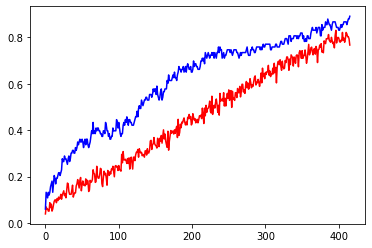

In [72]:
acc_train = round(history.history['accuracy'][-1]*100,2)
acc_val = round(history.history['val_accuracy'][-1]*100,2)
print(acc_train, acc_val)

plt.plot(history.history['accuracy'], c="r")
plt.plot(history.history['val_accuracy'], c="b")

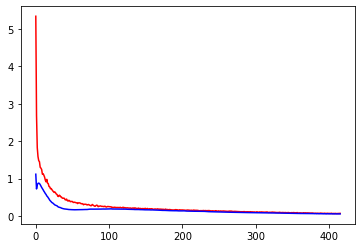

In [73]:
plt.plot(history.history['loss'], c="r")
plt.plot(history.history['val_loss'], c="b")

In [74]:
y_pred = model.predict(X_test)

y_classes = y_pred.argmax(axis=-1)

### Showing the confusion matrix

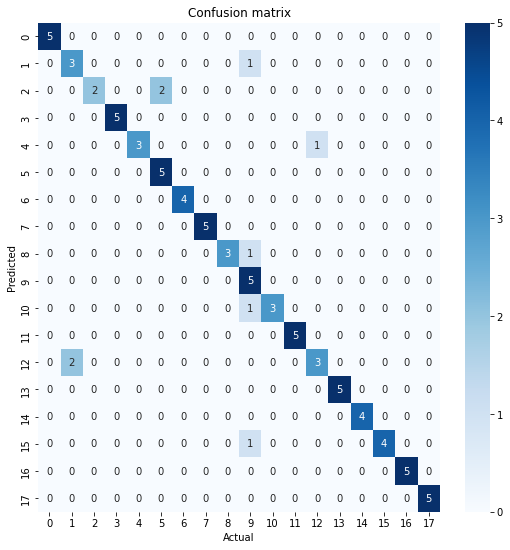

In [75]:
plt.rcParams["figure.figsize"] = (20,20)
aux_df = extracted_features_df[['class']].drop_duplicates().sort_values('class')
cm = confusion_matrix(np.argmax(df_Dm_test_y, axis=1), y_classes)
plt.figure(figsize=(9,9))
sns.heatmap(cm, 
            annot=True,
            xticklabels=aux_df['class'].values, 
            yticklabels=aux_df['class'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

### Showing the ROC curves

In [76]:
def plot_roc_curve(yactual, ypreds, yproba):
    fig = plt.figure(figsize=(15,15))
    ax1 = fig.add_subplot(221)
    skplt.metrics.plot_roc(yactual,yproba, ax=ax1)

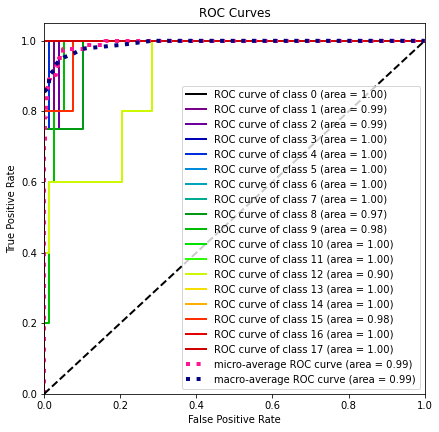

In [77]:
plot_roc_curve(y_test, y_classes, y_pred)

### Showing the accuracy

In [78]:
print(classification_report(y_test,y_classes))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.60      0.75      0.67         4
           2       1.00      0.50      0.67         4
           3       1.00      1.00      1.00         5
           4       1.00      0.75      0.86         4
           5       0.71      1.00      0.83         5
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         5
           8       1.00      0.75      0.86         4
           9       0.56      1.00      0.71         5
          10       1.00      0.75      0.86         4
          11       1.00      1.00      1.00         5
          12       0.75      0.60      0.67         5
          13       1.00      1.00      1.00         5
          14       1.00      1.00      1.00         4
          15       1.00      0.80      0.89         5
          16       1.00      1.00      1.00         5
          17       1.00    

## Saving the model

In [55]:
filename = './pickle/wild-animals-mfcc-neural-network-model.h5'
model.save(filename)

In [56]:
model = tf.keras.models.load_model(filename)

## Generating the results

In [57]:
### Now we iterate through every audio file and extract features 
### using Mel-Frequency Cepstral Coefficients
extracted_features_pred=[]
for index_num,row in tqdm(df_test.iterrows()):
    final_class_labels=row["classID"]
    relative_path=row["relative_path"]
    id_file=row["id_file"]
    data=features_extractor(relative_path)
    extracted_features_pred.append([data,final_class_labels, relative_path, id_file])

6it [00:00, 16.23it/s]C:\Users\berra\AppData\Roaming\Python\Python39\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
18it [00:03,  4.82it/s]


In [58]:
### converting extracted_features to Pandas dataframe
pred_extracted_features_df=pd.DataFrame(extracted_features_pred,columns=['feature','class', 'relative_path', 'id_file'])
pred_extracted_features_df.head()

,feature,class,relative_path,id_file
0,"[-49.504818, 188.00752, -6.2211556, 24.138762,...",1,./prediction set/bear/439441__asteroiderer__be...,3430f2
1,"[-297.32343, 60.361256, -24.801064, 25.67225, ...",2,./prediction set/crow/138344__unclesigmund__cr...,6392b0
2,"[-132.5561, -3.4847963, -70.13361, -6.567298, ...",3,./prediction set/dolphin/456151__jfournier18__...,632f1c
3,"[-371.95102, 19.31906, -48.707516, 57.69961, 0...",4,./prediction set/eagle/104911__kabit__eagle.wav,1c69c3
4,"[-123.02737, 153.23604, -98.92939, 19.550322, ...",5,./prediction set/elephant/139875__y89312__44.wav,968b94


In [59]:
X_pred=np.array(pred_extracted_features_df['feature'].tolist())

In [60]:
y_real_pred=np.array(pred_extracted_features_df['class'].tolist())

In [61]:
y_pred_test = model.predict(X_pred).argmax(axis=-1)

In [62]:
y_proba = model.predict(X_pred).max(axis=-1)

In [63]:
pred_extracted_features_df["Predicted_Class"] = y_pred_test

In [64]:
pred_extracted_features_df["Max_proba"] = y_proba

In [65]:
pred_extracted_features_df = pred_extracted_features_df[['id_file', 'relative_path', "Max_proba", 'Predicted_Class', 'class']]

### Showing the number of correct predictions

In [66]:
pred_extracted_features_df['Predicted_Class'] = le.inverse_transform(pred_extracted_features_df['Predicted_Class'])

In [67]:
pred_extracted_features_df['class'] = le.inverse_transform(pred_extracted_features_df['class'])

In [79]:
pred_extracted_features_df[pred_extracted_features_df["Predicted_Class"] == 
                          pred_extracted_features_df["class"]].shape

(15, 5)

In [80]:
pred_extracted_features_df.sort_values(by=["Max_proba"], ascending=False)

,id_file,relative_path,Max_proba,Predicted_Class,class
0,3430f2,./prediction set/bear/439441__asteroiderer__be...,1.000000,bear,bear
14,ee4054,./prediction set/snake/234269__moddingtr__snak...,1.000000,snake,snake
3,1c69c3,./prediction set/eagle/104911__kabit__eagle.wav,1.000000,eagle,eagle
2,632f1c,./prediction set/dolphin/456151__jfournier18__...,0.999892,dolphin,dolphin
17,f0c878,./prediction set/wolf/66258__viorelvio__sunetu...,0.998919,wolf,wolf
12,d69232,./prediction set/Penguin/463033__iamaviolin__p...,0.996782,Penguin,Penguin
13,313489,./prediction set/seal/179586__stormpetrel__a-w...,0.995101,seal,seal
7,ed4d9b,./prediction set/hippo/194871__toadie__hippos-...,0.986466,hippo,hippo
9,b17cb2,./prediction set/monkey/128473__darkozl__a-mon...,0.948439,monkey,monkey
11,254eda,./prediction set/panther/black-panther-roaring...,0.905901,panther,panther


In [81]:
pred_extracted_features_df.to_excel("./results/wils-animals-predictions-results.xlsx", index=False)